# Aman untuk Diminum
## Melatih Model *Machine Learning* untuk Mengenal Air yang Aman Diminum


### Pemerolehan Dataset dari Kaggle

1. Install Kaggle pada Colab

In [1]:
pip install kaggle

2. Unduh Kaggle API dari menu *Settings*, kemudian unggah ke Colab melalui fitur *Files* yang ada di kiri layar.
3. Dokumentasi ini menggunakan kode berikut untuk membuat *prompt* unggah data dan memindahkan data ke `/.kaggle`

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('Pengguna mengunggah file "{name}" dengan rentang {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json
Pengguna mengunggah file "kaggle (1).json" dengan rentang 63 bytes


4. Mengunduh dataset `water_potability.zip` dari Kaggle
5. `Unzip` dataset dan disimpan di `/content`

In [5]:
!kaggle datasets download -d adityakadiwal/water-potability

  0% 0.00/251k [00:00<?, ?B/s]
100% 251k/251k [00:00<00:00, 102MB/s]


In [6]:
!unzip water-potability.zip

Archive:  water-potability.zip
  inflating: water_potability.csv    


### Pemahaman terhadap Data dengan Analisis Data Eksploratori dan Preproses Data

1. *Import* terhadap *libraries* yang dibutuhkan

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

2. Memindahkan dataset `.csv` ke dalam DataFrame. Pada saat ini, *dataset* yang telah diunduh dari Kaggle terletak di `/content/water_potability.csv`

In [9]:
df = pd.read_csv('/content/water_potability.csv')

3. Pemeriksaan Dimensi Dataset

In [10]:
# Dimensi dataset
df.shape

(3276, 10)

Hasil dari `df.shape` menunjukkan bahwa dataset terdiri dari 3276 sampel (baris, *row*) yang tersebar pada 10 fitur (kolom, *column*, *features*)

4. Selayang pandang dataset: 4 sampel teratas dan tipe data yang digunakan.

In [11]:
# Selayang pandang dataset
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [12]:
# Tipe data tiap fitur/kolom
df.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

5. Pemeriksaan *Null Values* dan Resolusi Isu tersebut menggunakan *Random Forest*

In [13]:
# Pemeriksaan nilai kosong (null value)
df.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Dalam tahap pemeriksaan *null values* ditemukan beberapa *null values* yang tersebar di variabel `ph`, `Sulfate`, dan `Trihalomethanes`. Untuk memeriksa apakah ada pola tertentu dalam kemunculan *null values* ini, akan digunakan visualisasi.

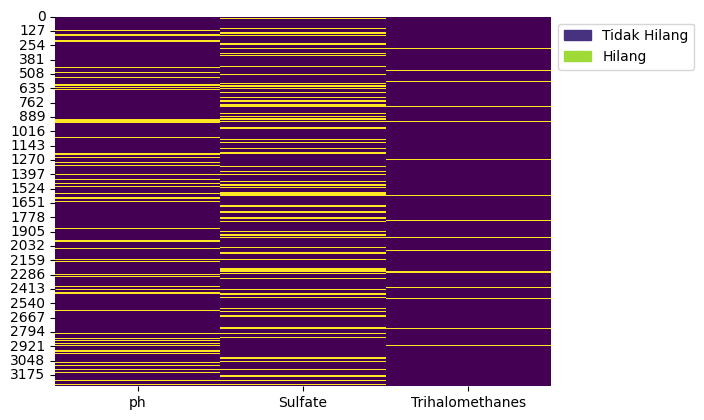

In [18]:
# Visualisasi null values
missing_data = df[['ph', 'Sulfate', 'Trihalomethanes']].isnull()
sns.heatmap(missing_data, cbar=False, cmap='viridis')

# Legenda
legend_labels = ['Tidak Hilang', 'Hilang']
color_map = [sns.color_palette('viridis')[0], sns.color_palette('viridis')[-1]]
legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in color_map]
plt.legend(legend_handles, legend_labels, bbox_to_anchor=(1.00, 1), loc='upper left')

plt.show()

Hasil menunjukkan bahwa *null values* (warna kuning) tidak muncul mengikuti pola tertentu, namun hanya muncul tersebardi beberapa tingkat. Sehingga untuk mengisi nilai-nilai kosong tersebut dapat digunakan metode Imputasi.

Untuk kasus ini, digunakan Imputasi berbasis Model dengan Model *Random Forest*. Digunakan demikian karena dataset ini akan menghasilkan nilai prediktif pada potabilitas (keterminuman) air, sehingga memiliki hipotesa yang kuat bahwa variabel dalam dataset ini saling berkorelasi satu sama lain.

In [21]:
# Library yang ditambah (dipindah ke atas)

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.impute import SimpleImputer

# Untuk keamanan, uji coba pengisian dataset dilakukan pada
# variabel yang berbeda yang merupakan salinan df

df_imputed = df.copy()

# Fitur yang akan digunakan pada metode Imputasi
features = ['Hardness', 'Solids', 'Chloramines', 'Conductivity', 'Organic_carbon', 'Turbidity']

# Iterasi pada kolom dengan nilai yang hilang
for column in ['ph', 'Sulfate', 'Trihalomethanes']:

    # Membuat mask untuk mengidentifikasi null values
    mask = df_imputed[column].isnull()

    # Memecah dataset kepada complete dan incomplete
    complete_cases = df_imputed.loc[~mask, features + [column]]
    incomplete_cases = df_imputed.loc[mask, features + [column]]

    # Memecah complete cases kepada fitur dan target
    X_train = complete_cases[features]
    y_train = complete_cases[column]

    # Fitting random forest regressor
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)

    # Menggunakan regressor untuk mengisi null values
    X_impute = incomplete_cases[features]
    y_impute = rf.predict(X_impute)

    # Menggunakan identifikasi mask, hasil regressor di masukkan ke
    # dalam dataframe salinan
    df_imputed.loc[mask, column] = y_impute

# Tampilkan untuk pengecekan apakah semua null values sudah terisi
print(df_imputed.isnull().sum())

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


Dapat terlihat dari hasil ini, bahwa *null values* sudah tidak ditemukan pada dataset. Perlu diingat bahwa kita melakukan penyalinan dari variabel `df` ke `df_imputed` sehingga perlu dilakukan penulisan ulang dari variabel `df`.

In [22]:
# Menggantikan nilai pada variabel df menjadi berisi nilai pada variabel df_imputed
df = df_imputed

6. Deskripsi statistik dataset setelah dilakukan proses imputasi

In [23]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000,3276.000000
mean,7.081592,196.369496,22014.092526,7.122277,333.841279,426.205111,14.284970,66.424043,3.966786,0.390110
std,1.482964,32.879761,8768.570828,1.583085,36.913490,80.824064,3.308162,15.787242,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.252710,176.850538,15666.690297,6.127421,314.436976,365.734414,12.065801,56.647656,3.439711,0.000000
50%,7.057285,196.967627,20927.833607,7.130299,333.499870,421.884968,14.218338,66.630736,3.955028,0.000000
75%,7.897372,216.667456,27332.762127,8.114887,352.798770,481.792304,16.557652,76.696337,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


Dari hasil `df.describe()` dapat dilihat bahwa seluruh nilai `count` sudah setara (3276 sampel) yang menunjukkan bahwa *null values* sudah tidak ditemukan pada dataset.

Untuk menginterpretasikan sisa data pada hasil `df.describe()` dilakukan visualisasi fitur numerik.

7. Visualisasi Fitur Numerik

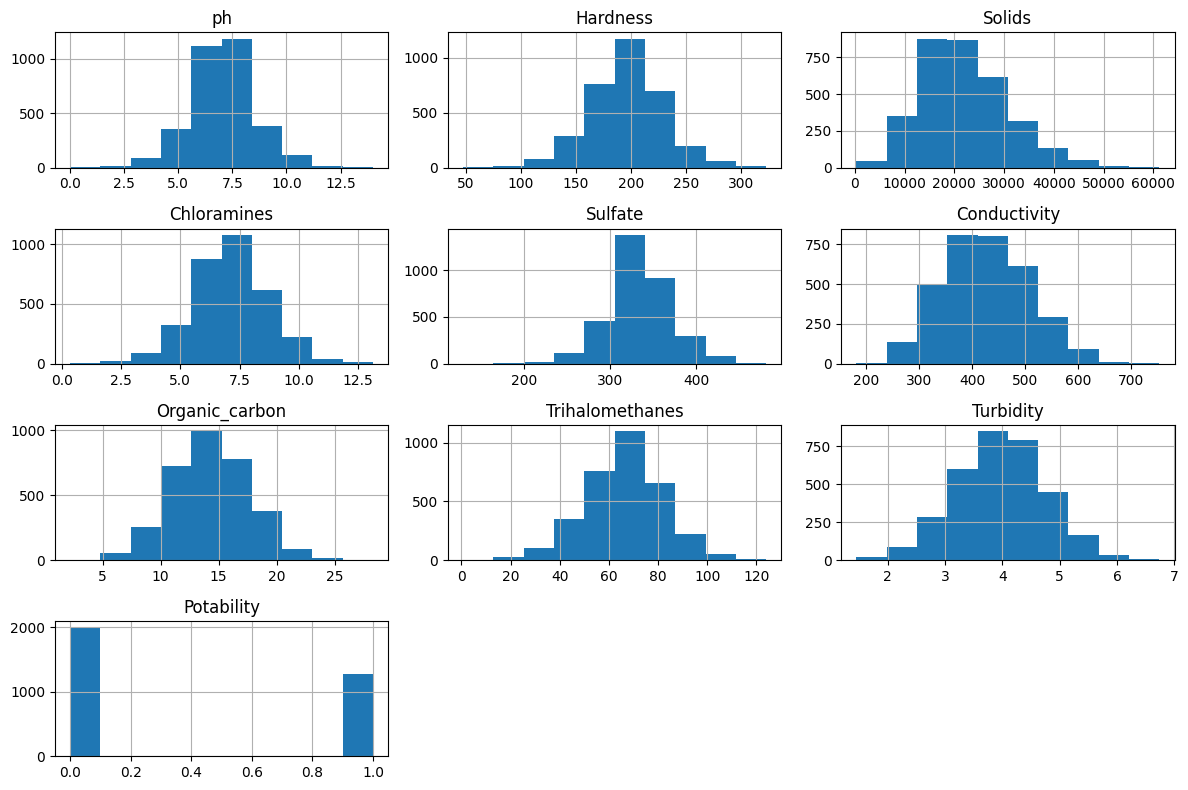

In [43]:
# Histogram
df.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()

Karena variabel `Solids` menunjukkan tendensi (*skewness*) ke kanan, maka dilakukan evaluasi terhadap tendensi ini.

Perlu diingat bahwa tiap feature saat ini memiliki skala yang berbeda karena menggunakan metrik pengukuran yang berbeda, hingga saat ini penanganan hanya per feature, tidak seluruhnya.

Untuk memahami *skewness* lihat [disini](https://www.scribbr.com/statistics/skewness/)

In [44]:
# Hitung Skewness tiap fitur
skewness = df.skew()

# Tampilan skewness pada fitur
print("Nilai Skewness:")
for feature, skew in skewness.items():
    print(f"Skewness dari '{feature}': {skew}")

Nilai Skewness:
Skewness dari 'ph': 0.025420266604009093
Skewness dari 'Hardness': -0.0393417047767249
Skewness dari 'Solids': 0.6216344855169127
Skewness dari 'Chloramines': -0.01209844012438221
Skewness dari 'Sulfate': -0.04994596723336346
Skewness dari 'Conductivity': 0.2644902239264119
Skewness dari 'Organic_carbon': 0.025532582090242492
Skewness dari 'Trihalomethanes': -0.08969459765367085
Skewness dari 'Turbidity': -0.007816642377392604
Skewness dari 'Potability': 0.4507837491078628


Melihat bahwa nilai *Skewness* tidak lebih dari 1, dan dekat dengan 0, seharusnya bisa diabaikan. Namun, melihat pada grafik, dapat disimpulkan bahwa fitur `Solids` adalah yang paling problematik, memiliki *skewness value* yang paling tinggi.

Untuk mengatasinya akan digunakan *Square Root Transformation*. Alasan penggunaan adalah transformasi tersebut menjaga (*retain*) urutan besaran angka.

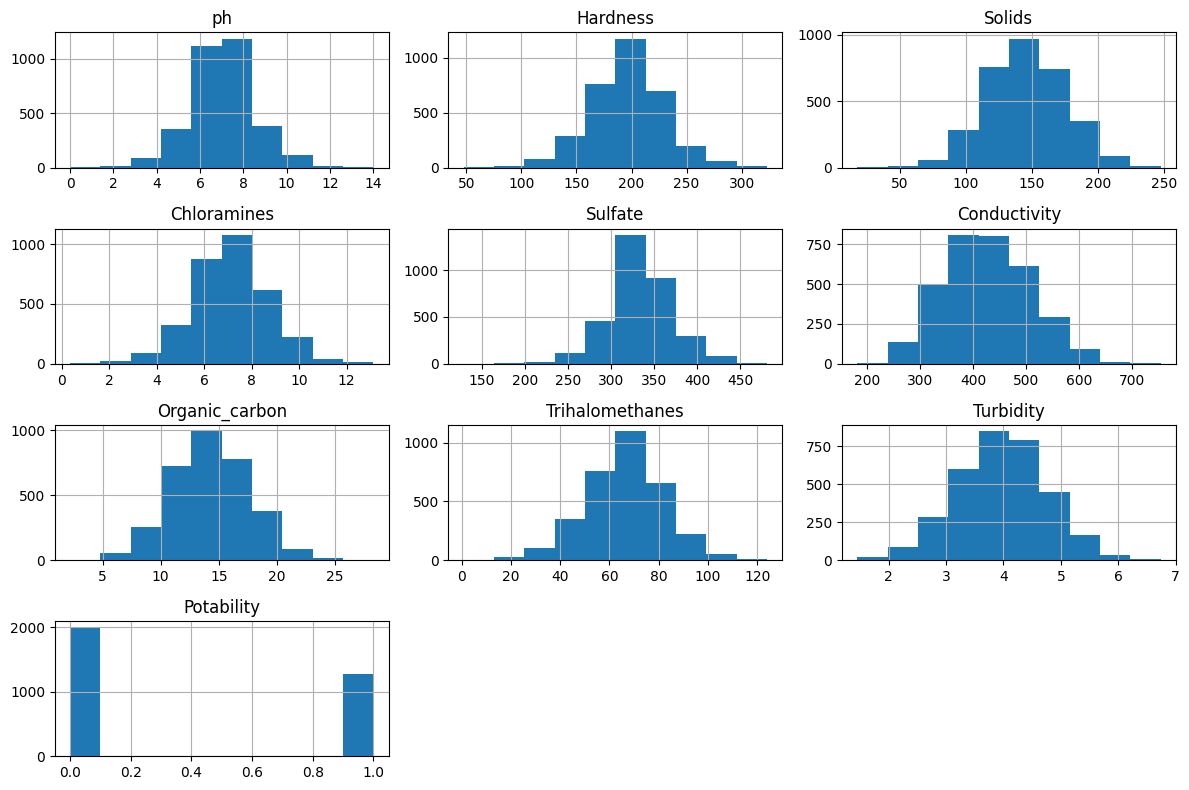

In [45]:
# Membuat variabel baru untuk keamanan
df_transformed = df.copy()

# Square Root Transformation pada DF
df_transformed['Solids'] = np.sqrt(df['Solids'])

# Histogram Terbaru
df_transformed.hist(figsize=(12, 8))
plt.tight_layout()
plt.show()


In [46]:
# Skewness terbaru
skewness = df_transformed.skew()

# Tampilkan skewness
print("Nilai skewness pd tiap fitur")
for feature, skew in skewness.items():
    print(f"Skewness dari '{feature}': {skew}")

Nilai skewness pd tiap fitur
Skewness dari 'ph': 0.025420266604009093
Skewness dari 'Hardness': -0.0393417047767249
Skewness dari 'Solids': -0.015157793420941885
Skewness dari 'Chloramines': -0.01209844012438221
Skewness dari 'Sulfate': -0.04994596723336346
Skewness dari 'Conductivity': 0.2644902239264119
Skewness dari 'Organic_carbon': 0.025532582090242492
Skewness dari 'Trihalomethanes': -0.08969459765367085
Skewness dari 'Turbidity': -0.007816642377392604
Skewness dari 'Potability': 0.4507837491078628


Menggunakan hasil dari proses transformasi menggunakan akar kuadrat ditampilkan diatas, dapat disimpulkan bahwa *skewness* pada `Solids` dapat dikurangi.

In [47]:
# Memperbarui nilai Solids pada df
df['Solids'] = df_transformed['Solids']

In [48]:
new_skew=df['Solids'].skew()
print(new_skew)

-0.015157793420941885


8. *Outlier* pada data: Visualisasi dengan Box Plot

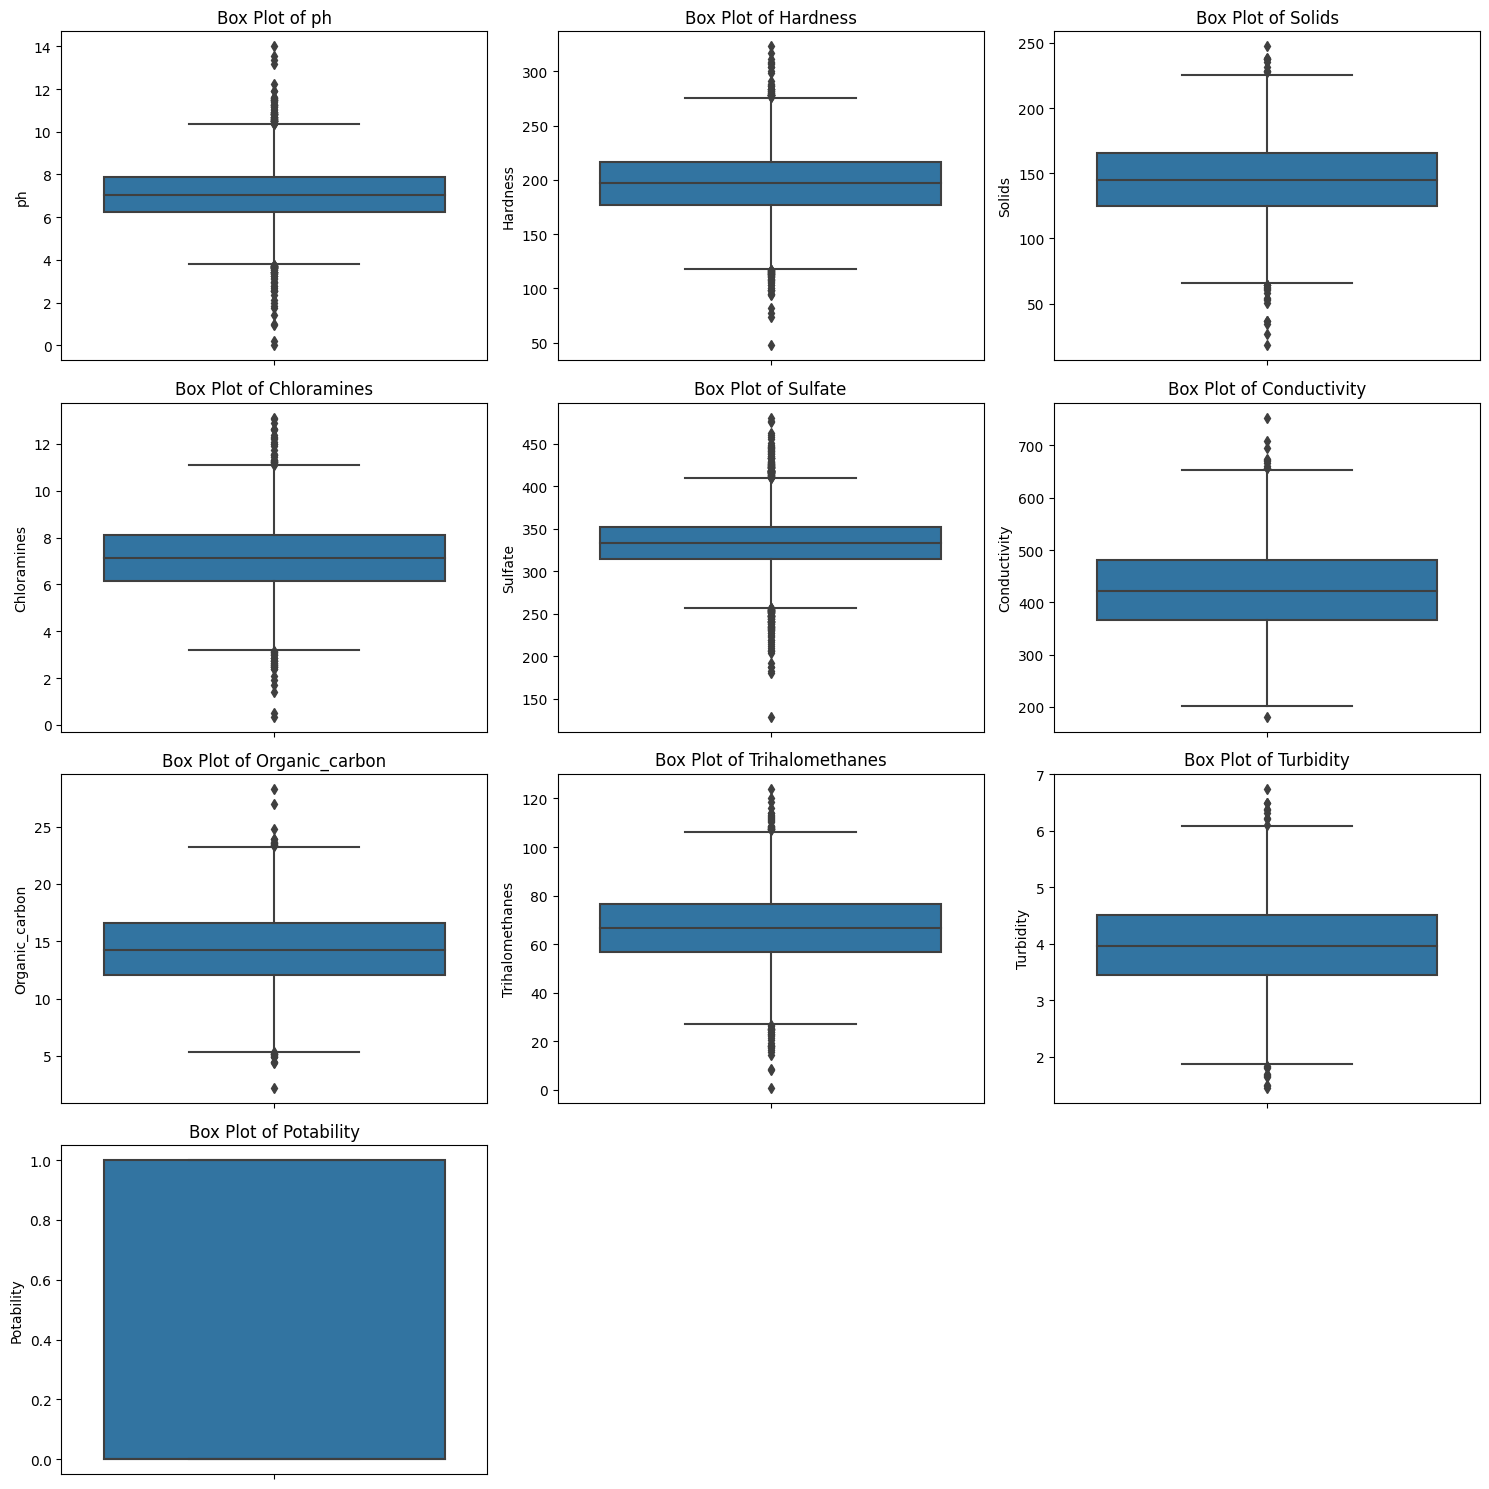

In [51]:
# Set the number of columns and rows for subplots
num_cols = 3
num_rows = (len(df.columns) - 1) // num_cols + 1

# Create subplots for box plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# Flatten the axes array to iterate over the subplots
axes = axes.flatten()

# Iterate over each feature and create a box plot in each subplot
for i, column in enumerate(df.columns):
    sns.boxplot(data=df, y=column, ax=axes[i])
    axes[i].set_title(f"Box Plot of {column}")
    axes[i].set_ylabel(column)

# Remove any extra subplots
if len(df.columns) < num_rows * num_cols:
    for j in range(len(df.columns), num_rows * num_cols):
        fig.delaxes(axes[j])

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()

Hingga saat ini Potability diabaikan karena hanya berisi 0 dan 1 untuk menyatakan bahwa air bisa diminum atau tidak.

Model yang akan dikembangkan akan menggunakan random forest, karena algoritma random forest andal dalam menangani outlier.

## Pengembangan Model

1. Pemecahan dataset menjadi fitur-fitur (X) dan target variabel `Potability`

In [52]:
X = df.drop('Potability', axis=1)
y = df['Potability']

2. Pemecahan lanjutan menjadi variabel train dan test.

In [54]:
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52)

3. *Feature scaling* dilakukan untuk menyamakan metrik pada dataset, karena masing-masing data menggunakan metrik pengukuran yang berbeda. Fitting scaler dilakukan pada data train untuk mencegah bocornya test data ke train data.

In [56]:
# from sklearn.preprocessing import StandardScaler

# Panggil StandardScaler
scaler = StandardScaler()

# Fit scaler thd train data
scaler.fit(X_train)

# Transform data train dan test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Untuk memeriksa apakah feature scaling berhasil, `X_train_scaled` dan `X_train` dibandingkan.

X_train_scaled Deskriptif
                 ph      Hardness        Solids   Chloramines       Sulfate  \
count  2.620000e+03  2.620000e+03  2.620000e+03  2.620000e+03  2.620000e+03   
mean   7.919026e-16 -1.545837e-16  5.518910e-16  7.051187e-17  2.204174e-15   
std    1.000191e+00  1.000191e+00  1.000191e+00  1.000191e+00  1.000191e+00   
min   -4.747484e+00 -4.559410e+00 -4.288173e+00 -4.270362e+00 -5.629046e+00   
25%   -5.566646e-01 -5.850630e-01 -6.767471e-01 -6.293378e-01 -5.180383e-01   
50%   -1.553460e-02  1.794686e-02 -1.262078e-02 -2.003669e-03 -3.083572e-03   
75%    5.406078e-01  6.127037e-01  6.650371e-01  6.301807e-01  4.986935e-01   
max    4.629484e+00  3.866169e+00  3.419504e+00  3.803796e+00  3.932062e+00   

       Conductivity  Organic_carbon  Trihalomethanes     Turbidity  
count  2.620000e+03    2.620000e+03     2.620000e+03  2.620000e+03  
mean   3.322194e-16   -1.613637e-16     6.603708e-16  1.179718e-16  
std    1.000191e+00    1.000191e+00     1.000191e+00  1

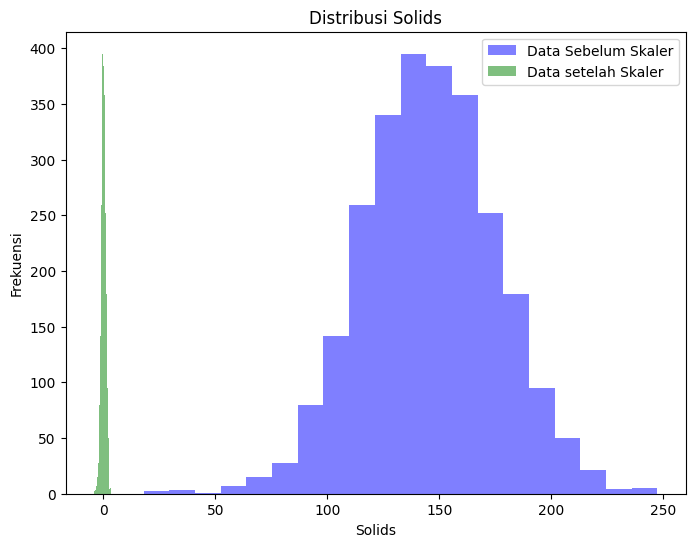

In [60]:
# DataFraming
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Tampilkan Statistik Deskriptif masing-masing X_train_scaled dan X_train
print("X_train_scaled Deskriptif")
print(X_train_scaled_df.describe())
print("\nX_train Deskriptif:")
print(X_train.describe())

# Histogram Solids untuk membandingkan
feature = 'Solids'
plt.figure(figsize=(8, 6))
plt.hist(X_train[feature], bins=20, color='blue', alpha=0.5, label='Data Sebelum Skaler')
plt.hist(X_train_scaled_df[feature], bins=20, color='green', alpha=0.5, label='Data setelah Skaler')

plt.title(f"Distribusi {feature}")
plt.xlabel(feature)
plt.ylabel("Frekuensi")
plt.legend()
plt.show()

Dari deskriptif dan contoh dari variabel `Solids`, data sudah di *scale* dengan mengurangi besar value namun tetap mempertahankan variabilitas.

4. Melatih model dengan Algoritma Random Forest.

In [64]:
# from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=52)

In [65]:
# melatih model dengan X_train_scaled dan y_train

model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=52)

Sampai tahap ini model telah dilatih, kemudian langkah selanjutnya adalah evaluasi model dengan melakukan test.

5. Evaluasi Model

In [67]:
# Membuat prediksi pada fitur test
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_test_scaled)

In [69]:
# Metrik evaluasi

# Accuracy/Keakuratan
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Confusion/Kebingungan Model
confusion_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_mat)

# Classification Report/Laporan Klasifikasi
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

Accuracy: 0.676829268292683
Confusion Matrix:
 [[356  46]
 [166  88]]
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.89      0.77       402
           1       0.66      0.35      0.45       254

    accuracy                           0.68       656
   macro avg       0.67      0.62      0.61       656
weighted avg       0.67      0.68      0.65       656



Dari matriks pengujian diatas dapat dilihat:

* Akurasi model 67.68% ini berarti 67.68% dari sampel air pada dataset test diklasifikasikan secara akurat baik antara bisa diminum (1) atau tidak bisa diminum (0)
* Pada confusion matrix terdapat 4 nilai, nilai pertama adalah 356, yang merupakan True Positives, bermakna model mengidentifikasikan secara tepat 356 sampel sebagai air dapat diminum.
* Kedua, nilai True Negative 88, bermakna model secara akurat mengidentifikasi 88 sampel sebagai air tidak dapat diminum.
* Ketiga, nilai False Negative 46, yang bermakna model melakukan kesalahan klasifikasi 46 sampel air yang aslinya dapat diminum, menjadi diklasifikasikan sebagai air tidak dapat diminum.
* Keempat, nilai False Positive 166, berarti model melakukan kesalahan klasifikasi 166 sampel yang tidak bisa diminum, dan mengklasifikasikannya sebagai air yang bisa diminum.

## Tuning Model dengan Feature Selection

Karena akurasi model masih 67.68%, dilakukan Feature Selection. Seleksi fitur dilakukan untuk memilih fitur yang memiliki pengaruh pada target (`potability`).

In [83]:
# Latih Model
model.fit(X_train_scaled, y_train)

# Analisis kepentingan fitur
feature_importances = model.feature_importances_

In [85]:
# Urutkan kepentingan fitur
indices = np.argsort(feature_importances)[::-1]

# Pilih fitur dengan urutan kepentingan top 5
k = 5
top_k_features = X_train.columns[indices][:k]

In [86]:
# Buat variabel baru
X_train_selected = X_train[top_k_features]
X_test_selected = X_test[top_k_features]

In [88]:
# Uji Ulang
# Membuat model random forest dengan n_estimators=300
model_selected = RandomForestClassifier(n_estimators=300, random_state=52)

# Latih model dengan fitur terpilih
model_selected.fit(X_train_selected, y_train)

# Prediksi
y_pred_selected = model_selected.predict(X_test_selected)

# Evaluasi
accuracy_selected = accuracy_score(y_test, y_pred_selected)
confusion_mat_selected = confusion_matrix(y_test, y_pred_selected)
classification_rep_selected = classification_report(y_test, y_pred_selected)

print("Accuracy (Selected Features):", accuracy_selected)
print("Confusion Matrix (Selected Features):\n", confusion_mat_selected)
print("Classification Report (Selected Features):\n", classification_rep_selected)

Accuracy (Selected Features): 0.6783536585365854
Confusion Matrix (Selected Features):
 [[342  60]
 [151 103]]
Classification Report (Selected Features):
               precision    recall  f1-score   support

           0       0.69      0.85      0.76       402
           1       0.63      0.41      0.49       254

    accuracy                           0.68       656
   macro avg       0.66      0.63      0.63       656
weighted avg       0.67      0.68      0.66       656



Dari hasil usaha tuning menggunakan seleksi fitur, tidak ditemukan peningkatan yang signifikan dari akurasi model, ini bisa terjadi karena:

* Jumlah data yang kurang
* Algoritma yang digunakan tidak tepat.

Namun perlu digaris bawahi bahwa model ini mampu mengidentifikasi hampir 68% secara akurat antara air yang bisa diminum dan tidak diminum.